c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\kaasa\AppData\Local\Temp\ipykernel_35232\917891755.py:141: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  bicubic_upscale = transforms.Resize((img_height * 4, img_width * 4), interpolation=Image.BICUBIC)(img)


1.0 0.0
1.0 0.0
1.0 0.0


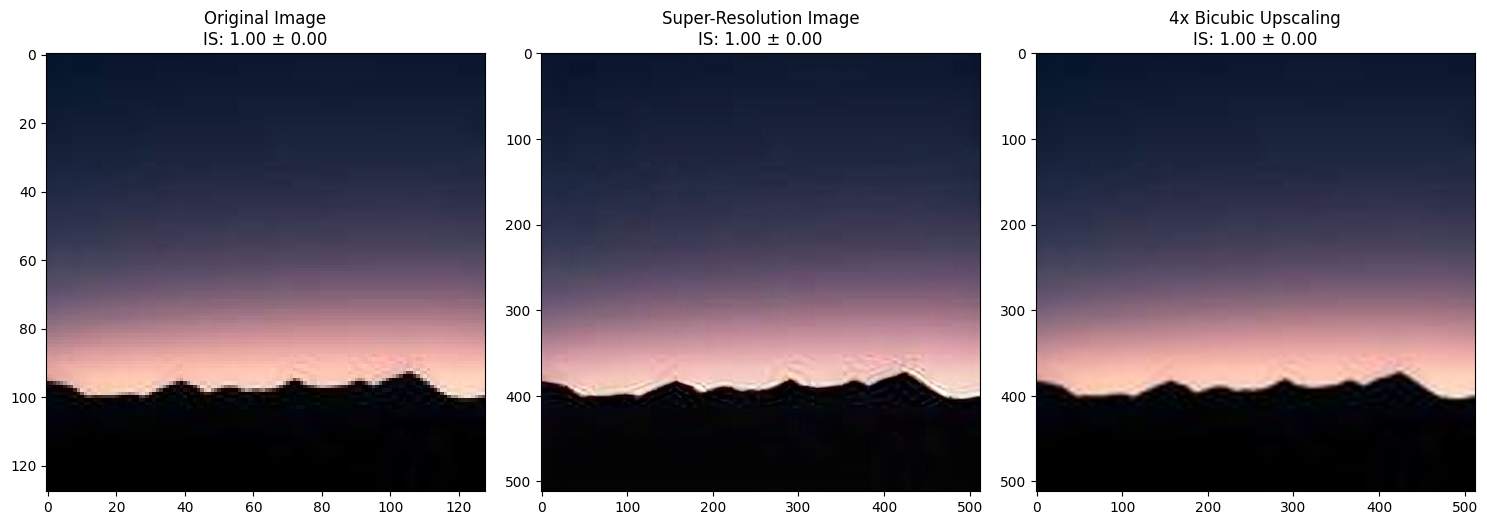

In [17]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import os
import numpy as np
import config

from torchvision.models import inception_v3
from torchvision import models
import torch.nn.functional as F
from scipy.stats import entropy


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_act, **kwargs):
        super().__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            **kwargs,
            bias=True,
        )
        self.act = nn.LeakyReLU(0.2, inplace=True) if use_act else nn.Identity()

    def forward(self, x):
        return self.act(self.cnn(x))


class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        self.conv = nn.Conv2d(in_c, in_c, 3, 1, 1, bias=True)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.act(self.conv(self.upsample(x)))


class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels, channels=32, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.blocks = nn.ModuleList()

        for i in range(5):
            self.blocks.append(
                ConvBlock(
                    in_channels + channels * i,
                    channels if i <= 3 else in_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    use_act=True if i <= 3 else False,
                )
            )

    def forward(self, x):
        new_inputs = x
        for block in self.blocks:
            out = block(new_inputs)
            new_inputs = torch.cat([new_inputs, out], dim=1)
        return self.residual_beta * out + x


class RRDB(nn.Module):
    def __init__(self, in_channels, residual_beta=0.2):
        super().__init__()
        self.residual_beta = residual_beta
        self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels) for _ in range(3)])

    def forward(self, x):
        return self.rrdb(x) * self.residual_beta + x


class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=23):
        super().__init__()
        self.initial = nn.Conv2d(
            in_channels,
            num_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
        )
        self.residuals = nn.Sequential(*[RRDB(num_channels) for _ in range(num_blocks)])
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1)
        self.upsamples = nn.Sequential(
            UpsampleBlock(num_channels), UpsampleBlock(num_channels),
        )
        self.final = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, 3, 1, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(num_channels, in_channels, 3, 1, 1, bias=True),
        )

    def forward(self, x):
        initial = self.initial(x)
        x = self.conv(self.residuals(initial)) + initial
        x = self.upsamples(x)
        return self.final(x)


# Load the pre-trained Generator model
model = Generator()
checkpoint = torch.load("gen.pth", map_location="cuda")
model.load_state_dict(checkpoint["state_dict"])
model.to("cuda")
model.eval()

# Load InceptionV3
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.to("cuda")
inception_model.eval()

# Download a random image from the internet
img_height = 128
img_width = 128
url = f'https://picsum.photos/{img_width}/{img_height}'
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Apply the test transform to the input image
input_image = config.test_transform(image=np.asarray(img))["image"].unsqueeze(0).to("cuda")

# Generate the super-resolution image
with torch.no_grad():
    upscaled_img = model(input_image)

# Convert the upscaled image tensor to a PIL image
upscaled_img = upscaled_img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
upscaled_img = (upscaled_img * 255.0).clip(0, 255).astype('uint8')
upscaled_img = Image.fromarray(upscaled_img)

# Perform 4x bicubic upscaling for comparison
bicubic_upscale = transforms.Resize((img_height * 4, img_width * 4), interpolation=Image.BICUBIC)(img)

def prepare_inception(imgs):
    if isinstance(imgs, list):
        imgs = torch.stack([transforms.ToTensor()(img) for img in imgs], dim=0)
        imgs = imgs.to(torch.float32).to("cuda")  # Convert to float32 and move to GPU
        return imgs
    elif isinstance(imgs, np.ndarray):
        if imgs.ndim == 3:  # Single image, add batch dimension
            imgs = np.expand_dims(imgs, axis=0)
        imgs = np.moveaxis(imgs, -1, 2)  # Move channels to the second dimension
        imgs = torch.from_numpy(imgs).to(torch.float32).to("cuda")  # Convert to float32 and move to GPU
        return imgs
    else:
        raise ValueError("Unsupported image type")

# Calculate Inception Score
def inception_score(imgs, inception_model, device='cuda', batch_size=32, resize=False, splits=1):
    N = len(imgs)
    imgs = np.stack([np.array(img) for img in imgs], axis=0)  # Stack images along the first dimension
    imgs = prepare_inception(imgs.transpose((0, 3, 1, 2)))

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Get predictions
    preds = []
    for batch in dataloader:
        batch = batch.to(device)
        pred = inception_model(batch)
        preds.append(F.softmax(pred, dim=1).detach().cpu().numpy())
    preds = np.concatenate(preds, axis=0)

    # Calculate KL divergence and Inception Score
    split_scores = []
    for k in range(splits):
        part = preds[k * (N // splits): (k + 1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    return np.mean(split_scores), np.std(split_scores)

# Compute Inception Score for original, bicubic, and super-resolution images
original_score, original_std = inception_score([img], inception_model)
bicubic_score, bicubic_std = inception_score([bicubic_upscale], inception_model)
upscaled_score, upscaled_std = inception_score([upscaled_img], inception_model)

print(original_score, original_std)
print(bicubic_score, bicubic_std )
print(upscaled_score, upscaled_std )

# Plot the original image, super-resolution image, and bicubic upscaling
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img)
axs[0].set_title('Original Image\nIS: {:.2f} ± {:.2f}'.format(original_score, original_std))
axs[1].imshow(upscaled_img)
axs[1].set_title('Super-Resolution Image\nIS: {:.2f} ± {:.2f}'.format(upscaled_score, upscaled_std))
axs[2].imshow(bicubic_upscale)
axs[2].set_title('4x Bicubic Upscaling\nIS: {:.2f} ± {:.2f}'.format(bicubic_score, bicubic_std))

plt.tight_layout()
plt.show()

In [ ]:
import os
import cv2

video_path = "./Video/lowRes/speech.mp4"

# Open the video file
video = cv2.VideoCapture(video_path)

# Get the video properties
fps = video.get(cv2.CAP_PROP_FPS)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Set the output video path
output_path = "./Video/HighRes/speech.mp4"

# Create a VideoWriter object for saving the output video
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
output_video = cv2.VideoWriter(output_path, fourcc, fps, (width * 4, height * 4))

# Process the video frame by frame
while True:
    ret, frame = video.read()
    if not ret:
        break

    # Convert the frame from BGR to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Convert the frame to a PIL image
    img = Image.fromarray(frame)

    # Apply the test transform to the input frame
    input_frame = config.test_transform(image=np.asarray(img))["image"].unsqueeze(0).to("cuda")

    # Generate the super-resolution frame
    with torch.no_grad():
        upscaled_frame = model(input_frame)

    # Convert the upscaled frame tensor to a numpy array
    upscaled_frame = upscaled_frame.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    upscaled_frame = (upscaled_frame * 255.0).clip(0, 255).astype('uint8')

    # Convert the upscaled frame from RGB to BGR
    upscaled_frame = cv2.cvtColor(upscaled_frame, cv2.COLOR_RGB2BGR)

    # Write the upscaled frame to the output video
    output_video.write(upscaled_frame)

# Release the video objects
video.release()
output_video.release()

print(f"Upscaled video saved as '{output_path}'.")